In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import jacobian
import scipy
import matplotlib.pyplot as plt

In [2]:
def kl_mvn(to, fr):
    """Calculate `KL(to||fr)`, where `to` and `fr` are pairs of means and covariance matrices"""
    m_to, S_to = to
    m_fr, S_fr = fr
    
    d = m_fr - m_to
    
    c, lower = scipy.linalg.cho_factor(S_fr)
    def solve(B):
        return scipy.linalg.cho_solve((c, lower), B)
    
    def logdet(S):
        return np.linalg.slogdet(S)[1]

    term1 = np.trace(solve(S_to))
    term2 = logdet(S_fr) - logdet(S_to)
    term3 = d.T @ solve(d)
    return (term1 + term2 + term3 - len(d))/2.

In [3]:

# class VAE(nn.Module):
#     def __init__(self, input_dim, hidden_dim, latent_dim):
#         super(VAE, self).__init__()

#         # Encoder layers
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc_mu = nn.Linear(hidden_dim, latent_dim)     # Outputs the mean
#         self.fc_short_encode = nn.Linear(input_dim, latent_dim)    # shortcut to the latent space

#         self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # Outputs the log variance

#         # Decoder layers
#         self.fc3 = nn.Linear(latent_dim, hidden_dim)
#         self.fc4 = nn.Linear(hidden_dim, input_dim)
#         self.fc_short_decode = nn.Linear(latent_dim, input_dim)    # shortcut to the input space

#     def encode(self, x):
#         """Encodes input by mapping it into the latent space."""
#         h1 = F.relu(self.fc1(x))
#         mu = self.fc_mu(h1) + self.fc_short_encode(x)
#         logvar = self.fc_logvar(h1)
#         return mu, logvar

#     def reparameterize(self, mu, logvar):
#         """Applies the reparameterization trick to sample from N(mu, var)."""
#         std = torch.exp(0.5 * logvar)   # Calculate the standard deviation
#         eps = torch.randn_like(std)     # Sample from standard normal
#         return mu + eps * std           # Sample from N(mu, var)

#     def decode(self, z):
#         """Decodes the latent representation z to reconstruct the input."""
#         h3 = F.relu(self.fc3(z))
#         # x_recon = torch.sigmoid(self.fc4(h3))
#         x_recon = self.fc4(h3) + self.fc_short_decode(z)

#         return x_recon

#     def forward(self, x):
#         """Defines the computation performed at every call."""
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         x_recon = self.decode(z)
#         return x_recon, mu, logvar

# def loss_function(recon_x, x, mu, logvar):
#     """Computes the VAE loss function."""
#     # Reconstruction loss (binary cross entropy)
#     # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

#     MSE = F.mse_loss(recon_x, x, reduction='sum')

#     # KL divergence between the approximate posterior and the prior
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.05

#     # KLD = 0

#     return MSE + KLD


In [4]:

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)     # Outputs the mean
        self.fc_short_encode = nn.Linear(input_dim, latent_dim)    # shortcut to the latent space

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        self.fc_short_decode = nn.Linear(latent_dim, input_dim)    # shortcut to the input space

    def encode(self, x):
        """Encodes input by mapping it into the latent space."""
        h1 = F.relu(self.fc1(x))
        mu = self.fc2(h1) + self.fc_short_encode(x)
        return mu


    def decode(self, z):
        """Decodes the latent representation z to reconstruct the input."""
        h3 = F.relu(self.fc3(z))
        # x_recon = torch.sigmoid(self.fc4(h3))
        x_recon = self.fc4(h3) + self.fc_short_decode(z)

        return x_recon

    def forward(self, x):
        """Defines the computation performed at every call."""
        mu = self.encode(x)
        x_recon = self.decode(mu)
        return x_recon, mu

def loss_function(recon_x, x, mu, kl_lambda=0.05):
    """Computes the VAE loss function."""
    # Reconstruction loss (binary cross entropy)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    MSE = F.mse_loss(recon_x, x, reduction='mean')

    encode_mu = mu.mean(0)
    encode_cov = torch.cov(mu.T)

    # KL divergence between the approximate posterior and the prior
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.05
    
    KLD = kl_lambda * 0.5 * (torch.trace(encode_cov) + torch.dot(encode_mu, encode_mu) - len(encode_mu) - torch.logdet(encode_cov))

    # KLD = 0

    return MSE + KLD


In [5]:
seed = 1
n = 500000
d = 10

np.random.seed(seed)
# A1_vector = np.random.normal(0, 1, d)
# A2_vector = np.random.normal(0, 1, d)

A1_vector = np.random.uniform(0.8, 1.2, d)
A2_vector = np.random.uniform(0.8, 1.2, d)

A1 = np.diag(A1_vector)
A2 = np.diag(A2_vector)

B1 = np.random.normal(0, 1, d)
B2 = np.random.normal(0, 1, d)

In [6]:
np.random.seed(seed)
X = np.random.normal(0, 1, (n, d))
Y1 = X * A1_vector + B1
Y2 = X * A2_vector + B2
Y = np.random.normal(0, 1, (n, d))


Y1 = torch.from_numpy(Y1).float()
Y2 = torch.from_numpy(Y2).float()
Y = torch.from_numpy(Y).float()

In [7]:
g1_inverse_true = (Y - B1) / A1_vector
g2_inverse_true = (Y - B2) / A2_vector
d1 = d
d2 = d

In [8]:
g1_inverse_true.pow(2).sum(1)

tensor([17.1204,  8.1893, 21.7644,  ..., 24.4307, 17.5329, 18.1688],
       dtype=torch.float64)

In [9]:
g2_inverse_true.pow(2).sum(1)

tensor([ 7.4468,  8.2733, 17.9244,  ..., 14.6267, 12.2714,  8.6099],
       dtype=torch.float64)

In [10]:

from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
input_dim = Y1.size(1)   # Dimension of the input data
hidden_dim = 50        # Size of the hidden layer
latent_dim = 10         # Dimension of the latent space
batch_size = 1000        # Batch size for training
learning_rate = 5e-3    # Learning rate
epochs = 20             # Number of training epochs




In [11]:
# # Create DataLoader
# dataset1 = TensorDataset(Y1)
# dataloader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True)

# # Initialize the VAE model
# model1 = VAE(input_dim, hidden_dim, latent_dim)
# optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=1e-3)

# for epoch in range(epochs):
#     model1.train()
#     train_loss = 0
#     for data_batch in dataloader1:
#         data = data_batch[0]
#         break
#     break


In [12]:
# recon_batch, mu = model1(data)

In [13]:
# encode_mu = mu.mean(0)
# encode_cov = torch.cov(mu.T)

# 0.5 * (torch.trace(encode_cov) + torch.dot(encode_mu, encode_mu) - len(encode_mu) - torch.logdet(encode_cov))


In [14]:
# Create DataLoader
dataset1 = TensorDataset(Y1)
dataloader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True)

# Initialize the VAE model
model1 = VAE(input_dim, hidden_dim, latent_dim)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=1e-3)

# Training loop
for epoch in range(epochs):
    model1.train()
    train_loss = 0
    for data_batch in dataloader1:
        data = data_batch[0]
        optimizer1.zero_grad()
        recon_batch, mu = model1(data)
        loss = loss_function(recon_batch, data, mu)
        # loss = loss / batch_size
        loss.backward()
        train_loss += loss.item() * batch_size
        optimizer1.step()
    average_loss = train_loss / len(dataset1)
    print(f'Epoch {epoch + 1}, Average Loss: {average_loss:.4f}')

/Users/yansun/opt/anaconda3/envs/llmenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Average Loss: 0.0528
Epoch 2, Average Loss: 0.0028
Epoch 3, Average Loss: 0.0024
Epoch 4, Average Loss: 0.0021
Epoch 5, Average Loss: 0.0021
Epoch 6, Average Loss: 0.0020
Epoch 7, Average Loss: 0.0020
Epoch 8, Average Loss: 0.0020
Epoch 9, Average Loss: 0.0020
Epoch 10, Average Loss: 0.0020
Epoch 11, Average Loss: 0.0020
Epoch 12, Average Loss: 0.0020
Epoch 13, Average Loss: 0.0020
Epoch 14, Average Loss: 0.0020
Epoch 15, Average Loss: 0.0020
Epoch 16, Average Loss: 0.0020
Epoch 17, Average Loss: 0.0020
Epoch 18, Average Loss: 0.0020
Epoch 19, Average Loss: 0.0020
Epoch 20, Average Loss: 0.0020


In [15]:
model1_test = VAE(input_dim, hidden_dim, latent_dim)

In [16]:
with torch.no_grad():
    for para in model1_test.parameters():
        para.data.zero_()

In [17]:
with torch.no_grad():
    model1_test.fc_short_encode.weight.data = torch.FloatTensor(np.diag(np.power(A1_vector, -1)))
    model1_test.fc_short_encode.bias.data = torch.FloatTensor(-B1 * np.power(A1_vector, -1))

    model1_test.fc_short_decode.weight.data = torch.FloatTensor(np.diag(A1_vector))
    model1_test.fc_short_decode.bias.data = torch.FloatTensor(B1)

In [18]:
# print(model1_test.encode(Y1)[0])
# print((Y1 - B1) / A1_vector)
# print(model1_test.decode(model1_test.encode(Y1)[0]))
# print(Y1)

In [19]:
with torch.no_grad():
    data = Y2[0:100,]
    recon_batch, mu = model1(data)
    loss1 = loss_function(recon_batch, data, mu)
    # print(F.mse_loss(recon_batch, data, reduction='sum'))
    # print(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.05)
    # print(F.mse_loss(recon_batch, data, reduction='sum') + -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.05)
    
    recon_batch_test, mu_test = model1_test(data)
    loss1_test = loss_function(recon_batch_test, data, mu_test)
    # print(F.mse_loss(recon_batch_test, data, reduction='sum'))
    # print(-0.5 * torch.sum(1 + logvar_test - mu_test.pow(2) - logvar_test.exp()) * 0.05)
    # print(F.mse_loss(recon_batch_test, data, reduction='sum') + -0.5 * torch.sum(1 + logvar_test - mu_test.pow(2) - logvar_test.exp()) * 0.05)
    print(f'Loss1: {loss1:.4f}, Loss1_test: {loss1_test:.4f}')

Loss1: 0.2073, Loss1_test: 0.2157


In [20]:
# print(model1.fc_short_encode.weight.data)
print(model1.fc_short_encode.bias.data)
# print(model1_test.fc_short_encode.weight.data)
print(model1_test.fc_short_encode.bias.data)

tensor([ 0.2262, -0.4309, -0.1828,  0.3690,  0.0486,  0.2419, -0.4305, -0.3529,
         0.0490,  0.0984])
tensor([-1.1727,  1.0108,  0.2155,  0.9532, -0.0492, -0.6964,  1.2586, -1.2201,
        -0.9404, -0.4948])


In [21]:
print(model1.fc1.weight.data.max())
print(model1.fc1.weight.data.min())
print(model1.fc2.weight.data)
print(model1.fc2.bias.data)

tensor(0.0843)
tensor(-0.0636)
tensor([[-1.6329e-27,  9.5454e-41,  2.2095e-01,  2.1066e-41, -4.7148e-41,
         -9.6901e-41, -9.9872e-36,  1.1956e-40, -2.1482e-41, -2.5569e-25,
         -1.1488e-12, -7.8642e-41, -1.0932e-40,  1.0590e-40, -5.7064e-41,
         -1.2818e-37, -3.6352e-41, -1.5636e-41, -1.9454e-41,  4.4420e-09,
          1.3991e-16,  3.4019e-41, -4.4302e-41,  1.2512e-40,  1.3668e-17,
         -1.0342e-37, -5.2977e-41,  8.4692e-41,  1.0747e-40, -9.6942e-42,
         -5.9114e-41, -6.9929e-41,  3.5957e-42, -5.7410e-41,  8.4261e-41,
          1.1375e-40,  4.9937e-41,  4.7290e-41,  1.9001e-01, -2.8533e-41,
          2.0037e-41,  6.6420e-41, -3.5369e-41,  2.5624e-41,  2.0088e-38,
          4.0705e-41,  3.3544e-41,  5.5004e-03, -4.9903e-39, -1.0486e-41],
        [ 1.6756e-27, -1.4808e-41, -3.5912e-01,  1.5344e-42,  9.2779e-41,
          2.9245e-42, -6.9523e-36, -1.8684e-41,  2.5728e-41, -1.1183e-24,
         -2.7593e-12,  1.0421e-40,  2.6564e-41, -1.4925e-41, -1.5468e-41,
      

In [22]:
print((Y - model1.decode(model1.encode(Y))).pow(2).sum(1).mean())
print((Y2 - model1.decode(model1.encode(Y2))).pow(2).sum(1).mean())
print((Y1 - model1.decode(model1.encode(Y1))).pow(2).sum(1).mean())

tensor(0.0674, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0013, grad_fn=<MeanBackward0>)


In [23]:
print(np.power(model1.encode(Y1).data, 2).sum(1).mean())
print(np.power((Y1 - B1) / A1_vector, 2).sum(1).mean())

print(np.power(model1.encode(Y).data, 2).sum(1).mean())
print(np.power((Y - B1) / A1_vector, 2).sum(1).mean())

print(np.power(model1.encode(Y2).data, 2).sum(1).mean())
print(np.power((Y2 - B1) / A1_vector, 2).sum(1).mean())

tensor(9.9484)
tensor(9.9927, dtype=torch.float64)
tensor(19.2384)
tensor(19.9754, dtype=torch.float64)
tensor(18.5883)
tensor(19.0084, dtype=torch.float64)


In [24]:
# Create DataLoader
dataset2 = TensorDataset(Y2)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

# Initialize the VAE model
model2 = VAE(input_dim, hidden_dim, latent_dim)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=1e-3)

# Training loop
for epoch in range(epochs):
    model2.train()
    train_loss = 0
    for data_batch in dataloader2:
        data = data_batch[0]
        optimizer2.zero_grad()
        recon_batch, mu = model2(data)
        loss = loss_function(recon_batch, data, mu)
        # loss = loss / batch_size
        loss.backward()
        train_loss += loss.item() * batch_size
        optimizer2.step()
    average_loss = train_loss / len(dataset2)
    print(f'Epoch {epoch + 1}, Average Loss: {average_loss:.4f}')

Epoch 1, Average Loss: 0.0538
Epoch 2, Average Loss: 0.0027
Epoch 3, Average Loss: 0.0021
Epoch 4, Average Loss: 0.0020
Epoch 5, Average Loss: 0.0019
Epoch 6, Average Loss: 0.0020
Epoch 7, Average Loss: 0.0020
Epoch 8, Average Loss: 0.0019
Epoch 9, Average Loss: 0.0020
Epoch 10, Average Loss: 0.0020
Epoch 11, Average Loss: 0.0020
Epoch 12, Average Loss: 0.0020
Epoch 13, Average Loss: 0.0020
Epoch 14, Average Loss: 0.0020
Epoch 15, Average Loss: 0.0020
Epoch 16, Average Loss: 0.0020
Epoch 17, Average Loss: 0.0019
Epoch 18, Average Loss: 0.0020
Epoch 19, Average Loss: 0.0019
Epoch 20, Average Loss: 0.0020


In [25]:
print((Y - model2.decode(model2.encode(Y))).pow(2).sum(1).mean())
print((Y2 - model2.decode(model2.encode(Y2))).pow(2).sum(1).mean())
print((Y1 - model2.decode(model2.encode(Y1))).pow(2).sum(1).mean())

tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)


In [26]:
print(np.power(model2.encode(Y2).data, 2).sum(1).mean())
print(np.power((Y2 - B2) / A2_vector, 2).sum(1).mean())

print(np.power(model2.encode(Y).data, 2).sum(1).mean())
print(np.power((Y - B2) / A2_vector, 2).sum(1).mean())

print(np.power(model2.encode(Y1).data, 2).sum(1).mean())
print(np.power((Y1 - B2) / A2_vector, 2).sum(1).mean())

tensor(9.9333)
tensor(9.9927, dtype=torch.float64)
tensor(15.2222)
tensor(15.5861, dtype=torch.float64)
tensor(17.9734)
tensor(18.0592, dtype=torch.float64)


In [27]:
num_samples = 1000

In [28]:
def g1_inverse_g2_function(x):
    mu = model1.encode(model2.decode(x))
    return mu

In [29]:
delta_list = []
std_list = []
for seed in range(500):
    if seed % 10 == 0:
        print(seed)
    np.random.seed(seed)
    # X = np.random.normal(0, 1, (n, d))
    # Y1 = X * A1_vector + B1
    # Y2 = X * A2_vector + B2
    Y = np.random.normal(0, 1, (n, d))
    Y = torch.from_numpy(Y).float()

    # g1_inverse = (Y - B1) / A1_vector
    # g2_inverse = (Y - B2) / A2_vector

    g1_inverse = model1.encode(Y).data
    g2_inverse = model2.encode(Y).data
    d1 = d
    d2 = d

    log_jacobian_list = []
    for index in range(num_samples):
        # if index % 10 == 0:
        #     print(index)
        z = torch.clone(g2_inverse[index:index+1,].data)
        z.requires_grad = True
        J_g1_inverse_g2 = jacobian(g1_inverse_g2_function, z)
        jacobian_g1_inverse_g2 = z.grad
        log_jacobian_list.append(torch.log(torch.det(J_g1_inverse_g2[0,:,0,:]).abs()).item())


    # delta_pp = np.log(np.abs(A2_vector / A1_vector)).sum() -0.5 * np.power(g1_inverse, 2).sum(1).mean() + 0.5 * np.power(g2_inverse, 2).sum(1).mean() + (d2 - d1) * np.log(2 * np.pi)
    # std_pp = (-0.5 * np.power(g1_inverse, 2).sum(1) + 0.5 * np.power(g2_inverse, 2).sum(1)).std() / np.sqrt(n)

    delta_pp = torch.FloatTensor(log_jacobian_list) -0.5 * np.power(g1_inverse, 2).sum(1)[0:num_samples]+ 0.5 * np.power(g2_inverse, 2).sum(1)[0:num_samples] + (d2 - d1) * np.log(2 * np.pi)
    std_pp = delta_pp.std()
    delta_pp = delta_pp.mean()

    delta_list.append(delta_pp)
    std_list.append(std_pp)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [30]:
# compare g_inverse norm  with the true g_inverse norm

print(-0.5 * np.power((Y - B1) / A1_vector, 2).sum(1).mean() + 0.5 * np.power((Y - B2) / A2_vector, 2).sum(1).mean() + (d2 - d1) * np.log(2 * np.pi))
print(-0.5 * np.power(g1_inverse, 2).sum(1).mean() + 0.5 * np.power(g2_inverse, 2).sum(1).mean() + (d2 - d1) * np.log(2 * np.pi))


tensor(-2.1886, dtype=torch.float64)
tensor(-2.0017)


In [31]:
# compare the log jacobian with the true log jacobian

print(torch.FloatTensor(log_jacobian_list).mean())
print(np.log(np.abs(A2_vector / A1_vector)).sum())

tensor(0.2976)
0.42535272172772054


In [32]:
# log_jacobian_list

In [33]:
# plt.hist(torch.FloatTensor(log_jacobian_list))

In [34]:
# delta_list

(array([  4.,  20.,  38.,  51.,  97., 119.,  76.,  48.,  28.,  19.]),
 array([-1.99994206, -1.94664669, -1.89335144, -1.84005606, -1.78676081,
        -1.73346543, -1.68017006, -1.6268748 , -1.57357943, -1.52028418,
        -1.4669888 ]),
 <BarContainer object of 10 artists>)

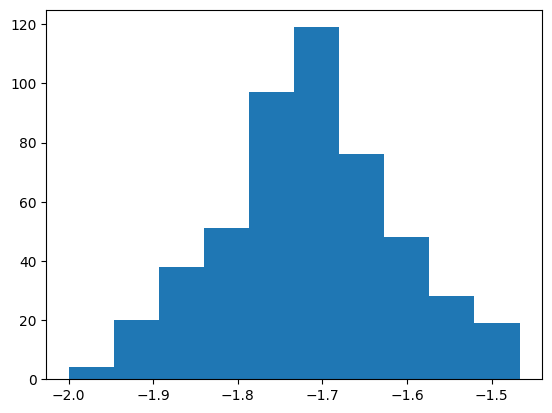

In [35]:
# histgoram of unnormalized statistics
plt.hist(delta_list)

In [36]:
mu = np.zeros(d)
sigma = np.diag(np.ones(d))

dist = -kl_mvn((mu, sigma), (B1, np.power(A1, 2))) + kl_mvn((mu, sigma), (B2, np.power(A2, 2)))
print(dist)

-1.7695912004473735


In [40]:
np.array(delta_list).mean()

-1.7150152

(array([  5.,  20.,  36.,  48.,  97., 120.,  81.,  45.,  29.,  19.]),
 array([-2.43245411, -1.873353  , -1.3142519 , -0.75515085, -0.19604978,
         0.3630513 ,  0.9221524 ,  1.4812535 ,  2.04035449,  2.5994556 ,
         3.1585567 ]),
 <BarContainer object of 10 artists>)

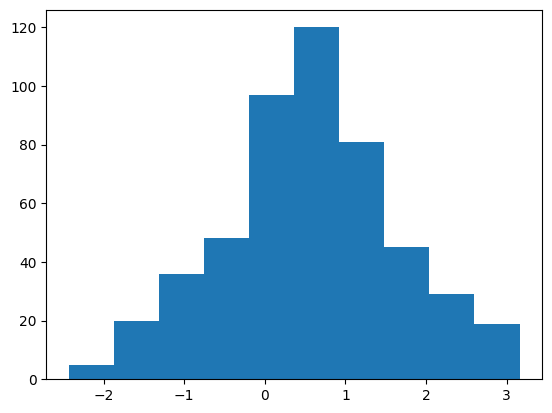

In [37]:
# histgoram of test statistics
plt.hist((np.array(delta_list) - dist) / (np.array(std_list) / np.sqrt(num_samples)))

In [38]:
# print((Y - model1.decode(model1.encode(Y)[0])).pow(2).sum(1).mean())
# print((Y2 - model1.decode(model1.encode(Y2)[0])).pow(2).sum(1).mean())
# print((Y1 - model1.decode(model1.encode(Y1)[0])).pow(2).sum(1).mean())

# print((Y - model2.decode(model2.encode(Y)[0])).pow(2).sum(1).mean())
# print((Y2 - model2.decode(model2.encode(Y2)[0])).pow(2).sum(1).mean())
# print((Y1 - model2.decode(model2.encode(Y1)[0])).pow(2).sum(1).mean())